# Data Wrangling of Medicare Part D Prescription Drug Coverage Data

In [1]:
import os

# Data Read/Write/Manipulation packages
import pandas as pd
import numpy as  np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics
from scipy.stats import pearsonr

### 2017 only questions

In [2]:
df = pd.read_csv('PartD_Prescriber_PUF_NPI_17.txt', sep='\t')
df.shape

(1162898, 84)

In [3]:
df.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,beneficiary_male_count,beneficiary_race_white_count,beneficiary_race_black_count,beneficiary_race_asian_pi_count,beneficiary_race_hispanic_count,beneficiary_race_nat_ind_count,beneficiary_race_other_count,beneficiary_nondual_count,beneficiary_dual_count,beneficiary_average_risk_score
0,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,92.0,220.0,14.0,0.0,0.0,0.0,0.0,143.0,91.0,2.1685
1,1003000142,KHALIL,RASHID,NaN,M.D.,M,I,4126 N HOLLAND SYLVANIA RD,SUITE 220,TOLEDO,...,92.0,195.0,58.0,NaN,NaN,0.0,NaN,143.0,133.0,1.8029
2,1003000167,ESCOBAR,JULIO,E,DDS,M,I,5 PINE CONE RD,NaN,DAYTON,...,17.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0598
3,1003000175,REYES-VASQUEZ,BELINDA,NaN,D.D.S.,F,I,322 N AZUSA AVE STE 202,NaN,LA PUENTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003000282,BLAKEMORE,ROSIE,K,FNP,F,I,TENNESSEE PRISON FOR WOMEN,3881 STEWARTS LANE,NASHVILLE,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,4.5148


In [4]:
df.dtypes

npi                                   int64
nppes_provider_last_org_name         object
nppes_provider_first_name            object
nppes_provider_mi                    object
nppes_credentials                    object
nppes_provider_gender                object
nppes_entity_code                    object
nppes_provider_street1               object
nppes_provider_street2               object
nppes_provider_city                  object
nppes_provider_zip5                 float64
nppes_provider_zip4                 float64
nppes_provider_state                 object
nppes_provider_country               object
specialty_description                object
description_flag                     object
medicare_prvdr_enroll_status         object
total_claim_count                     int64
total_30_day_fill_count             float64
total_drug_cost                     float64
total_day_supply                      int64
bene_count                          float64
ge65_suppress_flag              

Text(87.0, 0.5, 'Total # Transactions')

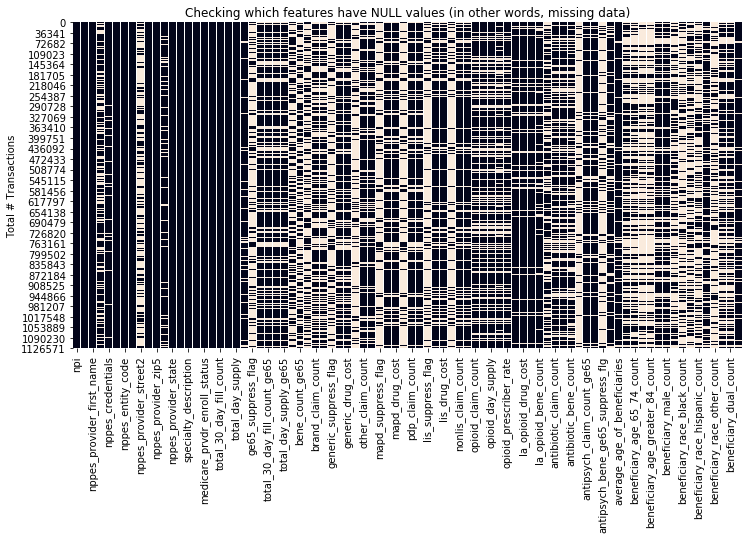

In [5]:
# look for missing data, visually
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Checking which features have NULL values (in other words, missing data)')
plt.ylabel('Total # Transactions')

### 1) Determine the average number of beneficiaries per provider. 
Due to the suppression of data with few beneficiaries, we can only include those with more than 10 beneficiaries.

In [6]:
# Since each of the NPIs provided correspond to a different provider, all we need to do is add up all of the
# beneficiaries across each age group; namely, beneficiary_age_less_65_count, 65_74, 75_84, 84+

all_beneficiaries_count = pd.concat([df.beneficiary_age_less_65_count, df.beneficiary_age_65_74_count,
                                    df.beneficiary_age_75_84_count, df.beneficiary_age_greater_84_count], axis=1)

print(np.floor(all_beneficiaries_count.sum(axis=1).mean()))

116.0


### 2) Work out for each Specialty the fraction of drug claims that are for brand-name drugs. 

Include only providers for whom the relevant information has not been suppressed, and consider only the specialities with at least 1000 total claims.

What is the standard deviation of these fractions?

In [7]:
claims_counts = pd.concat([df.specialty_description, df.total_claim_count, df.brand_claim_count], axis=1)

# keep only claims NPIs that processed at least 1000 total claims for the year
mod_claims_counts = claims_counts.loc[(claims_counts.total_claim_count>=1000)]

# Drop any providers that did not prescribe brand name drugs
mod_claim_counts_filtered = mod_claims_counts.dropna()

# Reset index
mod_claim_counts_filtered = mod_claim_counts_filtered.reset_index(drop=True)

# Calculate the fractions of brand name drugs and concatenate new dataframe to orig, then rename column at the end
brand_name_fraction = mod_claim_counts_filtered.brand_claim_count/mod_claim_counts_filtered.total_claim_count
mod_claims_counts_new = pd.concat([mod_claim_counts_filtered, brand_name_fraction], axis=1)
mod_claims_counts_new.columns = [*mod_claims_counts_new.columns[:-1], 'brand_claim_fraction']

# Group the claims by specialty_description, then take the mean value
mod_claim_counts_final = mod_claims_counts_new.groupby(['specialty_description']).mean()
print(mod_claim_counts_final.brand_claim_fraction)

# Calculate the standard deviation across grouped specialties
print()
print('The Standard Deviation Across them is: ', np.std(mod_claim_counts_final.brand_claim_fraction))

specialty_description
Addiction Medicine                                                0.220051
Allergy/ Immunology                                               0.357233
Anesthesiology                                                    0.123038
Anesthesiology Assistant                                          0.496649
Behavior Analyst                                                  0.096278
Cardiac Surgery                                                   0.178995
Cardiology                                                        0.201287
Certified Clinical Nurse Specialist                               0.131736
Certified Nurse Midwife                                           0.135443
Certified Registered Nurse Anesthetist (CRNA)                     0.183177
Chiropractic                                                      0.237809
Clinic or Group Practice                                          0.173975
Clinic/Center                                                     0.160099
Cli

### 3) Let's find which states have a surprisingly high supply of opiods, conditioned on specialty.
Work out the average length of an opiod prescription for each provider. 

For each (state, specialty) pair with at least 100 providers, calculate the average of this value across all providers.

Then find the ratio of this value to an equivalent quantity calculated from providers in each specialty across all states.

What is the largest such ratio?

In [8]:
# Assemble the data we need to tackle this
opioid_claims = pd.concat([df.specialty_description, df.nppes_provider_state, df.opioid_claim_count], axis=1)

opioid_claims_by_state_provider_counts = opioid_claims.groupby(['specialty_description', 'nppes_provider_state']).count()
#print(opioid_claims_by_state_provider_counts.head())
#print()

# Keep only the specialty providers within states that have over 100 NPIs getting down on the juice
mod_claims_counts = opioid_claims_by_state_provider_counts.loc[(opioid_claims_by_state_provider_counts.opioid_claim_count>=100)]
specialties_to_analyze = mod_claims_counts.index
#print(mod_claims_counts.head())
#print()

# Average opiod claims across all specialties
mod_claims_counts_across_specialty = mod_claims_counts.groupby('specialty_description').mean()
print(mod_claims_counts_across_specialty)

                                                    opioid_claim_count
specialty_description                                                 
Allergy/ Immunology                                         197.700000
Anesthesiology                                              235.600000
Cardiology                                                  389.000000
Certified Clinical Nurse Specialist                         204.000000
Certified Nurse Midwife                                     143.000000
Colorectal Surgery (Proctology)                             111.000000
Critical Care (Intensivists)                                127.000000
Dentist                                                    1270.260000
Dermatology                                                 308.833333
Diagnostic Radiology                                        196.125000
Emergency Medicine                                          780.000000
Endocrinology                                               215.785714
Family

In [9]:
opioid_claims_by_state_provider_counts = opioid_claims.groupby([ 'nppes_provider_state', 'specialty_description']).count()
#print(opioid_claims_by_state_provider_counts.head())
#print()

# Keep only the specialty providers within states that have over 100 NPIs getting down on the juice
mod_claims_counts_by_state = opioid_claims_by_state_provider_counts.loc[(opioid_claims_by_state_provider_counts.opioid_claim_count>=100)]
specialties_to_analyze = mod_claims_counts_by_state.index

#print(mod_claims_counts_by_state.index.get_level_values(1))
#print(mod_claims_counts_by_state)

## Condition Level 1 of the multi-level index on the specialty info from the previous block
opioid_claims_conditioned_on_specialty = mod_claims_counts_by_state.div(mod_claims_counts_across_specialty, level=1)
#print(opioid_claims_conditioned_on_specialty)

# Calculate max
max_ratio = np.max(opioid_claims_conditioned_on_specialty)
print(max_ratio)
print()
opioid_claims_conditioned_on_specialty.columns = [*opioid_claims_conditioned_on_specialty.columns[:-1], 'opioid_claim_count_ratio']
opioid_claims_conditioned_on_specialty.sort_values(by='opioid_claim_count_ratio', ascending=False)

opioid_claim_count    8.288813
dtype: float64



opioid_claim_count_ratio
nppes_provider_state specialty_description                                                       
NY                   Student in an Organized Health Care Education/T...                  8.288813
CA                   Internal Medicine                                                   6.180533
                     Dentist                                                             5.907452
                     Family Practice                                                     5.601272
                     Emergency Medicine                                                  5.234615
                     Psychiatry & Neurology                                              5.053562
NY                   Psychiatry & Neurology                                              4.970541
CA                   Psychiatry                                                          4.852230
NY                   Physician Assistant                                                 4.825453
PR                   General Practice                                                    4.803648
NY                   Psychiatry                                                          4.658309
CA                   Optometry                                                           4.605582
                     Physician Assistant                                                 4.457962
                     Ophthalmology                                                       4.366494
NY                   Dentist                                                             4.356588
CA                   Orthopedic Surgery                                                  4.313453
NY                   Internal Medicine                                                   4.252175
CA                   Pharmacist                                                          4.193628
                     Obstetrics & Gynecology                                             4.179966
NY                   Obstetrics & Gynecology                                             3.926075
                     Cardiology                                                          3.866324
CA                   Dermatology                                                         3.807879
NY                   Ophthalmology                                                       3.784470
FL                   Nurse Practitioner                                                  3.729752
CA                   General Surgery                                                     3.713466
TX                   Family Practice                                                     3.590977
FL                   Internal Medicine                                                   3.499206
CA                   Otolaryngology                                                      3.358255
                     Urology                                                             3.343396
PA                   Student in an Organized Health Care Education/T...                  3.305001
...                                                                                           ...
MT                   Emergency Medicine                                                  0.153846
VT                   Physician Assistant                                                 0.147884
MT                   Dentist                                                             0.144852
RI                   Dentist                                                             0.141703
DE                   Internal Medicine                                                   0.139808
DC                   Emergency Medicine                                                  0.139744
UT                   Student in an Organized Health Care Education/T...                  0.137813
VT                   Nurse Practitioner                                                  0.135365
DE                   Emergency Medicine                

### 4) For each provider, estimate the length of the average prescription using total_day_supply and total_claim_count.

What is the median, in days, of the distribution of this value across all providers?

In [10]:
# Assemble the data we need to tackle this
script_claims = pd.concat([df.total_day_supply, df.total_claim_count], axis=1)

#script_claims_by_state_provider_counts = opioid_claims.groupby(['specialty_description', 'nppes_provider_state']).count()
#print(opioid_claims_by_state_provider_counts.head())
#print()

# Calculate supply per claim
supply_per_claim = script_claims.total_day_supply.div(script_claims.total_claim_count)

# For display
script_claims_mod = pd.concat([script_claims, supply_per_claim], axis=1)
script_claims_mod.columns = [*script_claims_mod.columns[:-1], 'supply_days_per_claim']
print('The median value across all NPIs is: ', supply_per_claim.median())
print()
print(script_claims_mod)

The median value across all NPIs is:  29.7125748502994

         total_day_supply  total_claim_count  supply_days_per_claim
0                   14788                677              21.843427
1                   58605               1946              30.115622
2                     430                 55               7.818182
3                     150                 18               8.333333
4                    2681                 90              29.788889
5                   50677               2788              18.176829
6                    7587                200              37.935000
7                    1804                 45              40.088889
8                  337309               4981              67.719133
9                  333309               7165              46.519051
10                  30397                771              39.425422
11                    641                 25              25.640000
12                  18268                535              34

### 5) Find the ratio of beneficiaries with opioid prescriptions to beneficiaries with antibiotics prescriptions in each state.

Assume that each beneficiary attends only a single provider.  

What is the difference between the smallest and largest ratios?

In [11]:
# Put together the data that we need
opiods_and_antibiotics_count = pd.concat([df.nppes_provider_state, df.opioid_bene_count, df.antibiotic_bene_count], axis=1)

#print(opiods_and_antibiotics_count.head())
opiods_and_antibiotics_count_mod = opiods_and_antibiotics_count.groupby(['nppes_provider_state']).count()

# Since we're assuming that there is no overlap, we can do a straight divide
# Calculate opioid-to-antibiotic script ratios
opiods_and_antibiotics = opiods_and_antibiotics_count_mod.opioid_bene_count.div(opiods_and_antibiotics_count_mod.antibiotic_bene_count)

# For display
opiods_and_antibiotics_count_mod2 = pd.concat([opiods_and_antibiotics_count_mod, opiods_and_antibiotics], axis=1)
opiods_and_antibiotics_count_mod2.columns = [*opiods_and_antibiotics_count_mod2.columns[:-1], 'opioids_per_antibiotic']

max = np.max(opiods_and_antibiotics_count_mod2.opioids_per_antibiotic)
min = np.min(opiods_and_antibiotics_count_mod2.opioids_per_antibiotic)
print('The difference between the highest and lowest states are: ', max-min)
print()
#print(opiods_and_antibiotics_count_mod2.head())

opiods_and_antibiotics_count_mod2.sort_values(by='opioids_per_antibiotic', ascending=False)

The difference between the highest and lowest states are:  0.6666666666666667



,opioid_bene_count,antibiotic_bene_count,opioids_per_antibiotic
nppes_provider_state,,,
MP,17,12,1.416667
DC,2636,2218,1.188458
NY,61819,56210,1.099787
ZZ,108,99,1.090909
PA,39619,36339,1.090261
KY,12112,11191,1.082298
AL,10842,10031,1.080849
MO,15476,14468,1.069671
FL,51212,47926,1.068564


### 6) For each provider where the relevant columns are not suppressed, work out the fraction of beneficiaries age 65 and older, as well as the fraction of claims for beneficiaries with a low-income subsidy.

What is the Pearson correlation coefficient between these values?

In [12]:
# Put together the data that we need
# First the beneficiaries
all_beneficiaries_over_65_count = pd.concat([df.beneficiary_age_65_74_count,df.beneficiary_age_75_84_count, 
                                             df.beneficiary_age_greater_84_count], axis=1)
all_beneficiaries_over_65_count_mod = all_beneficiaries_over_65_count.sum(axis=1)

# Then the total claim count and low-income subsidy stuff 
bene_65_plus_lis_count = pd.concat([df.total_claim_count, df.lis_claim_count, all_beneficiaries_over_65_count_mod], axis=1)
bene_65_plus_lis_count.columns = [*bene_65_plus_lis_count.columns[:-1], 'bene_over_65_count']

# Drop rows that have NaN's and also those that have zeros (presumably these are too few to count and were filtered)
bene_65_plus_lis_count = bene_65_plus_lis_count.dropna()
bene_65_plus_lis_count = bene_65_plus_lis_count.loc[~(bene_65_plus_lis_count==0.0).any(1)]

# Reset indices
bene_65_plus_lis_count = bene_65_plus_lis_count.reset_index(drop=True)
#bene_65_plus_lis_count

# Calculate Ratios
lis_ratio = bene_65_plus_lis_count.lis_claim_count.div(bene_65_plus_lis_count.total_claim_count)
bene_over_65_ratio = bene_65_plus_lis_count.bene_over_65_count.div(bene_65_plus_lis_count.total_claim_count)
new_df = pd.concat([lis_ratio, bene_over_65_ratio],axis=1)

#--------------
X = new_df[0]
Y = new_df[1]

#new_df.plot.scatter(x=X, y=Y)
#-------------

corr, _ = pearsonr(X, Y)
print('Pearsons correlation: %.3f' % corr)

pearson_cc = np.cov(X, Y) / (np.std(X) * np.std(Y))
pearson_cc

Pearsons correlation: -0.250


array([[ 1.64598605, -0.25004839],
       [-0.25004839,  0.60754083]])

## 2016 and 2017 Data Questions

### 7) For each provider for whom the information is not suppressed, figure out the average cost per day of prescriptions in both 2016 and 2017.

Use this to estimate the inflation rate for daily prescription costs per provider

What is the average inflation rate across all providers?

In [13]:
df2 = pd.read_csv('PartD_Prescriber_PUF_NPI_16.txt', sep='\t')

In [14]:
# Assemble the data we need to tackle this
total_costs_2016_data = pd.concat([df2.npi, df2.total_drug_cost], axis=1)
total_costs_2017_data = pd.concat([df.npi, df.total_drug_cost], axis=1)
total_costs_2017_data.columns = [*total_costs_2017_data.columns[:-1], 'total_drug_cost_new']

# Set indices to be NPIs
total_costs_2016_data = total_costs_2016_data.set_index(['npi'])
total_costs_2017_data = total_costs_2017_data.set_index(['npi'])

# Now join
total_costs_data_annual = pd.merge(total_costs_2016_data, total_costs_2017_data, left_index=True, right_index=True)

# Per Day
total_costs_data_daily = total_costs_data_annual.div(365)

# Note; I'm not assuming any Consumer Price Index or anything; this is about providers
delta_costs = total_costs_data_daily.total_drug_cost_new.div(total_costs_data_daily.total_drug_cost)

print('The average inflation rate across all providers from 2016 to 2017 is: ', np.mean(delta_costs))
print()
print(delta_costs.head())
total_costs_data_daily.head()

The average inflation rate across all providers from 2016 to 2017 is:  2.284039972091077

npi
1003000126    0.970890
1003000142    1.003531
1003000167    1.127702
1003000282    1.648360
1003000407    0.968076
dtype: float64


,total_drug_cost,total_drug_cost_new
npi,,
1003000126,92.104603,89.423479
1003000142,382.728247,384.079479
1003000167,0.733726,0.827425
1003000282,12.567425,20.715644
1003000407,307.350986,297.538986


### 8) Consider all providers with a defined specialty in both years.  

Find the fraction of providers who left each specialty between 2016 and 2017.

What is the largest such fraction, when considering specialities with at least 1000 providers in 2016?

Note that some specialities have a fraction of 1 due to specialty name changes between 2016 and 2017; disregard these specialties in calculating your answer.

In [15]:
# Assemble the data that we need
specialities_2016 = pd.concat([df2.npi, df2.specialty_description], axis=1)
specialities_2017 = pd.concat([df.npi, df.specialty_description], axis=1)
specialities_2017.columns = [*specialities_2017.columns[:-1], 'specialty_description_new']

# Collect npi counts by specialty, ditch the 1's, consider only the big guns with @ least than 1000, 2016
specialities_2016_counts = specialities_2016.groupby(['specialty_description']).count()
specialities_2016_counts = specialities_2016_counts[specialities_2016_counts.npi != 1]
specialities_2016_counts = specialities_2016_counts[specialities_2016_counts.npi >= 1000]

# Collect npi counts by specialty, ditch the 1's, consider only the big guns with @ least than 1000, 2017
specialities_2017_counts = specialities_2017.groupby(['specialty_description_new']).count()
specialities_2017_counts = specialities_2017_counts[specialities_2017_counts.npi != 1]
specialities_2017_counts = specialities_2017_counts[specialities_2017_counts.npi >= 1000]

# Now join, because there are less in 2017 than in 2018
collect_specialties = pd.merge(specialities_2016_counts, specialities_2017_counts, left_index=True, right_index=True)

# Find the fraction that left, and figure out the largest
delta_providers = collect_specialties.npi_x - collect_specialties.npi_y

# Turn this number of providers into a fraction
delta_providers_fract = delta_providers.div(collect_specialties.npi_x)

# Create new DataFrame for summary
summary = pd.concat([collect_specialties, delta_providers, delta_providers_fract], axis=1)
print('The specialty that lost the most providers from 2016 to 2017 lost precisely: ', 
      np.max(delta_providers_fract), 'of them')
print()

summary.sort_values(by=1, ascending=False)

The specialty that lost the most providers from 2016 to 2017 lost precisely:  0.0815838426787138 of them



,npi_x,npi_y,0,1
Specialist,3763,3456,307,0.081584
Cardiac Surgery,1182,1096,86,0.072758
Pediatric Medicine,11744,10950,794,0.067609
Diagnostic Radiology,4421,4245,176,0.039810
General Practice,10171,9923,248,0.024383
Internal Medicine,133174,130302,2872,0.021566
Certified Clinical Nurse Specialist,2710,2652,58,0.021402
Anesthesiology,7180,7057,123,0.017131
Maxillofacial Surgery,1147,1139,8,0.006975
General Surgery,22944,22822,122,0.005317
